In [1]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import glob
# from glob import glob
import cv2
import numpy as np
import torch.nn.functional as F
import torch
from PIL import ImageOps
from PIL.Image import Image
from sympy.physics.control.control_plots import plt
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
# import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm

from torchvision.datasets import VOCSegmentation
import timm
import tqdm
import glob
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.transforms import RandomGamma
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
import glob
from torchvision.datasets import VOCSegmentation
import timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=51b5141d7d14aefba654a845065e061bcbe8fc88f064e866ac2235c11510acf7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=e7ab031d29de49dcfd6f13362cfc9b841abcb00ef398954aa9639997bf54f1de
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
trainsize = 256
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.CoarseDropout(p=0.2, max_height=35, max_width=35, fill_value=255),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.RandomShadow(p=0.1),
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.RandomCrop(trainsize, trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [5]:
# tham khảo "https://github.com/tungbt-k62/bkai-igh-neopolyp_SegFormer/blob/main/Medical_Image_Transformer.ipynb"
class BKpolypDataset(torch.utils.data.Dataset):
    def __init__(self, dir="path/to/data", transform=None):
        self.img_path_lst = []
        self.dir = dir
        self.transform = transform
        self.img_path_lst = glob.glob("{}/train/train/*".format(self.dir))

    def __len__(self):
        return len(self.img_path_lst)

    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, (trainsize, trainsize))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1
        # boundary RED color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))
        green_mask[green_mask != 0] = 2
        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = full_mask.astype(np.uint8)
        return full_mask

    def __getitem__(self, idx):
        img_path = self.img_path_lst[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (trainsize, trainsize))
        label_path = img_path.replace("train", "train_gt")
        label = self.read_mask(label_path)

        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed["image"]
            label = transformed["mask"]
        return image, label

In [12]:
train_dataset = BKpolypDataset(dir="/kaggle/input/bkai-igh-neopolyp", transform=train_transform)


In [6]:

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

tensor([0, 1], dtype=torch.uint8)
torch.Size([256, 256])


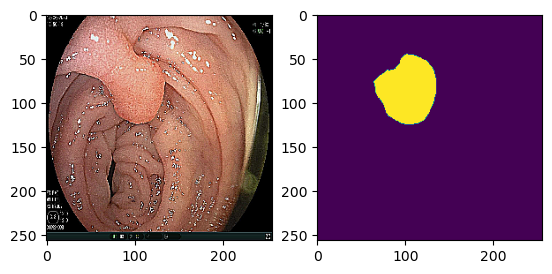

In [13]:
import random
id_test = random.randint(0, train_dataset.__len__())
sample1, sample2 = train_dataset.__getitem__(id_test)
print(torch.unique(sample2))
print(sample2.shape)
plt.subplot(1,2,1)
plt.imshow(unorm(sample1).permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(sample2.squeeze())
plt.show()

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            if out_channels*4 == in_channels:
                self.up_sample = nn.ConvTranspose2d(in_channels-out_channels*2, in_channels-out_channels*2, kernel_size=2, stride=2) 
            else:
                self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        else:
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
#         print("down", down_input.shape)
#         print("skip", skip_input.shape)
        x = self.up_sample(down_input)
#         print("x",x.shape)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class ColorizationModel(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(ColorizationModel, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [10]:
# class PolypModel(nn.Module):
#     def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
#         super(PolypModel, self).__init__()
#         self.up_sample_mode = up_sample_mode
#         # Downsampling Path
#         self.down_conv1 = DownBlock(3, 64)
#         self.down_conv2 = DownBlock(64, 128)
#         self.down_conv3 = DownBlock(128, 256)
#         self.down_conv4 = DownBlock(256, 512)
#         # Bottleneck
#         self.double_conv = DoubleConv(512, 1024)
#         # Upsampling Path
#         self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
#         self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
#         self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
#         self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
#         # Final Convolution
#         self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

#     def forward(self, x):
#         x, skip1_out = self.down_conv1(x)
# #         print(x.shape) 64 -112x112
# #         print("sk", skip1_out.shape) 64 224x224
#         x, skip2_out = self.down_conv2(x)
#         x, skip3_out = self.down_conv3(x)
#         x, skip4_out = self.down_conv4(x)
#         x = self.double_conv(x)
#         x = self.up_conv4(x, skip4_out)
#         x = self.up_conv3(x, skip3_out)
#         x = self.up_conv2(x, skip2_out)
#         x = self.up_conv1(x, skip1_out)
#         x = self.conv_last(x)
#         return x

In [11]:
# class PolypModel(nn.Module):
#     def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
#         super(PolypModel, self).__init__()
#         self.up_sample_mode = up_sample_mode
#         # Downsampling Path
#         self.down_conv1 = DownBlock(3, 64)
#         self.down_conv2 = DownBlock(64, 128)
#         self.down_conv3 = DownBlock(128, 256)
#         self.down_conv4 = DownBlock(256, 512)
#         # Bottleneck
#         self.double_conv = DoubleConv(512, 1024)
#         # Upsampling Path
#         self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
#         self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
#         self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
#         self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
#         # Final Convolution
#         self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
#         self.final_activation = nn.Softmax(dim=1)

#     def forward(self, x):
#         x, skip1_out = self.down_conv1(x)
#         x, skip2_out = self.down_conv2(x)
#         x, skip3_out = self.down_conv3(x)
#         x, skip4_out = self.down_conv4(x)
#         x = self.double_conv(x)
#         x = self.up_conv4(x, skip4_out)
#         x = self.up_conv3(x, skip3_out)
#         x = self.up_conv2(x, skip2_out)
#         x = self.up_conv1(x, skip1_out)
#         x = self.conv_last(x)
# #         print(x.shape)
# #         x = self.final_activation(x)
#         return x

In [10]:
# backbone
class PolypModel(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super().__init__()
        self.out_classes = out_classes
        self.backbone = timm.create_model("resnet152", pretrained=True, features_only=True)
#         self.down_conv1 = DownBlock(3, 64)
        self.down_conv1 = DownBlock(64, 128)
        self.down_conv2 = DownBlock(256, 512)
        self.down_conv3 = DownBlock(512, 1024)
        self.down_conv4 = DownBlock(1024, 2048)
        self.up_sample_mode = up_sample_mode
        self.block_neck = DoubleConv(2048, 1024)
        self.block_up1 = UpBlock(1024+1024, 512,self.up_sample_mode)
        self.block_up2 = UpBlock(512+512, 256,self.up_sample_mode)
        self.block_up3 = UpBlock(256+256, 128,self.up_sample_mode)
        self.block_up4 = UpBlock(128+64, 64,self.up_sample_mode)
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x)
        #x1 (B, 64, 128, 128) size/2
        #x2 (B, 256, 64, 64) size/4
        #x3 (B, 512, 32, 32) size/16
        #x4 (B, 1024, 16, 16) size/32
        #x5 (B, 2048, 8, 8) size/64
        x = self.block_neck(x5) # x (B, 1024, 8, 8)
        x = self.block_up1(x, x4)
        x = self.block_up2(x, x3)
        x = self.block_up3(x, x2)
        x = self.block_up4(x, x1 )
        x = self.conv_last(x)
        x = self.upsample(x)
        return x


In [14]:
learning_rate = 0.0001
batch_size = 32
num_epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model_segmentation = PolypModel().to(device)
# model_colorization = ColorizationModel().to(device)
checkpoint = torch.load('/kaggle/working/colorization_model_15.pth')
model_segmentation.load_state_dict(checkpoint['model_state_dict'])


# model_segmentation.down_conv1.load_state_dict(model_colorization.down_conv1.state_dict())
# model_segmentation.down_conv2.load_state_dict(model_colorization.down_conv2.state_dict())
# model_segmentation.down_conv3.load_state_dict(model_colorization.down_conv3.state_dict())
# model_segmentation.down_conv4.load_state_dict(model_colorization.down_conv4.state_dict())
# model_segmentation.down_conv1.requires_grad_(False)
# model_segmentation.down_conv2.requires_grad_(False)
# model_segmentation.down_conv3.requires_grad_(False)
# model_segmentation.down_conv4.requires_grad_(False)

optimizer = torch.optim.Adam(model_segmentation.parameters(), lr=learning_rate)
L_epoch = checkpoint['epoch']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



In [9]:
!pip install torchinfo
from torchinfo import summary



In [11]:

x = torch.randn(1, 3, 224, 224).to(device)  # Đảm bảo input và trọng số đều trên cùng một thiết bị

# output = model_segmentation(x)
summary(model_segmentation, (1,3,256,256))

Layer (type:depth-idx)                        Output Shape              Param #
PolypModel                                    [1, 3, 256, 256]          74,561,280
├─FeatureListNet: 1-1                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 64, 64]          70,400
│    └─Sequential: 2-6                        [1, 512, 32, 32]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 32, 32]         

In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# learning_rate = 0.0001
# batch_size = 2
# num_epochs = 3000
# criterion = nn.L1Loss()
# model = ColorizationModel().to(device)
# checkpoint = torch.load('/kaggle/input/model512/colorization_model_7 (2).pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# L_epoch = checkpoint['epoch']
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # optimizer = checkpoint['optimizer_state_dict']


In [10]:
BKpolypDataset(dir="/kaggle/input/bkai-igh-neopolyp", transform=train_transform)
train_size = int(0.9 * len(PolypDataset(images)))
print(train_size)
test_size = len(PolypDataset(images)) - train_size
print(test_size)
train_indices = list(range(train_size))
test_indices = list(range(train_size, train_size + test_size))

train_dataset = Subset(PolypDataset(images), train_indices)
test_dataset = Subset(PolypDataset(images), test_indices)
mask_dataset = Subset(PolypDatasetTest(images_mask), train_indices)
test_mask_dataset = Subset(PolypDatasetTest(images_mask), test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
mask_loader = DataLoader(mask_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_mask_loader = DataLoader(test_mask_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
print(len(test_loader))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508 in run_code        │
│                                                                                                  │
│   3505 │   │   │   │   if async_:                                                                │
│   3506 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3507 │   │   │   │   else:                                                                     │
│ ❱ 3508 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3509 │   │   │   finally:                                                                      │
│   3510 │   │   │   │   # Reset our crash handler in place                                        │
│   3511 │   │   │   │   sys.excepthook = old_excepthook                                           │
│                                                                                                  │
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 BKpolypDataset(dir="/kaggle/input/bkai-igh-neopolyp", transform=train_transform)            │
│ ❱  2 train_size = int(0.9 * len(PolypDataset(images)))                                           │
│    3 print(train_size)                                                                           │
│    4 test_size = len(PolypDataset(images)) - train_size                                          │
│    5 print(test_size)                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'PolypDataset' is not defined

In [15]:
train_size = 900
test_size = 100
train_indices = list(range(train_size))
test_indices = list(range(train_size, train_size + test_size))
train_dataset = Subset(BKpolypDataset(dir="/kaggle/input/bkai-igh-neopolyp", transform=train_transform), train_indices)
test_dataset = Subset(BKpolypDataset(dir="/kaggle/input/bkai-igh-neopolyp", transform=val_transform), test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)



In [ ]:
model_segmentation.train()
# for epoch in range(num_epochs):
for epoch in range(L_epoch, num_epochs):
    # Train on batches
    train_loss = 0
    for image, mask in train_loader:
        image=image.to(device)
        mask=mask.to(device)
        # Zero gradients
        optimizer.zero_grad()
#         RGB.permute(3, 2, 1, 0)
#         print(RGB.shape)
        # Forward pass
        outputs = model_segmentation(image)
        outputs = outputs.squeeze()
#         print(L.shape)
#         print(outputs.shape)
#         print(AB.shape)

        # Compute loss
        mask = mask.long()
#         print(outputs.shape)
#         print(RGBt.shape)
        loss = criterion(outputs, mask)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update train loss
        train_loss += loss.item()

    # Compute validation loss
    val_loss = 0
    with torch.no_grad():
        for image, mask in test_loader:
            image=image.to(device)
            mask=mask.to(device)
            # Forward pass
            outputs = model_segmentation(image)
            outputs = outputs.squeeze()
            mask = mask.long()

            # Compute loss
            loss = criterion(outputs, mask)

            # Update validation loss
            val_loss += loss.item()

    # Print loss
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")
    if (epoch+1)%100 ==0:
        checkpoint = {
        'epoch': epoch,
        'model_state_dict': model_segmentation.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }
        save_path = f'colorization_model_{epoch//100}.pth'

        torch.save(checkpoint, save_path)
torch.save(model_segmentation.state_dict(), 'colorization_model.pth')

Epoch 800/3000, Train Loss: 0.0070, Validation Loss: 0.0642
Epoch 801/3000, Train Loss: 0.0066, Validation Loss: 0.0590
Epoch 802/3000, Train Loss: 0.0065, Validation Loss: 0.0612
Epoch 803/3000, Train Loss: 0.0066, Validation Loss: 0.0580
Epoch 804/3000, Train Loss: 0.0076, Validation Loss: 0.0554
Epoch 805/3000, Train Loss: 0.0071, Validation Loss: 0.0554
Epoch 806/3000, Train Loss: 0.0070, Validation Loss: 0.0526
Epoch 807/3000, Train Loss: 0.0068, Validation Loss: 0.0573
Epoch 808/3000, Train Loss: 0.0071, Validation Loss: 0.0583
Epoch 809/3000, Train Loss: 0.0069, Validation Loss: 0.0551
Epoch 810/3000, Train Loss: 0.0078, Validation Loss: 0.0528
Epoch 811/3000, Train Loss: 0.0077, Validation Loss: 0.0545
Epoch 812/3000, Train Loss: 0.0089, Validation Loss: 0.0526
Epoch 813/3000, Train Loss: 0.0075, Validation Loss: 0.0494
Epoch 814/3000, Train Loss: 0.0075, Validation Loss: 0.0505
Epoch 815/3000, Train Loss: 0.0072, Validation Loss: 0.0601
Epoch 816/3000, Train Loss: 0.0069, Vali

In [ ]:
# for epoch in range(num_epochs):
# # for epoch in range(num_epochs):
# # for epoch in range(L_epoch, num_epochs):
#     # Train on batches
#     train_loss = 0
#     for RGB, RGBt in zip(train_loader,mask_loader):
#         RGB=RGB.to(device)
#         RGBt=RGBt.to(device)
#         # Zero gradients
#         optimizer.zero_grad()
# #         RGB.permute(3, 2, 1, 0)
# #         print(RGB.shape)
#         # Forward pass
#         outputs = model_segmentation(RGB)
#         outputs = outputs.squeeze()
# #         print(L.shape)
# #         print(outputs.shape)
# #         print(AB.shape)

#         # Compute loss
#         RGBt = RGBt.long()
# #         print(outputs.shape)
# #         print(RGBt.shape)
#         loss = criterion(outputs, RGBt)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Update train loss
#         train_loss += loss.item()

#     # Compute validation loss
#     val_loss = 0
#     with torch.no_grad():
#         for RGB, RGBt in zip(test_loader,test_mask_loader):
#             RGB=RGB.to(device)
#             RGBt=RGBt.to(device)
#             # Forward pass
#             outputs = model_segmentation(RGB)
#             outputs = outputs.squeeze()
#             RGBt = RGBt.long()

#             # Compute loss
#             loss = criterion(outputs, RGBt)

#             # Update validation loss
#             val_loss += loss.item()

#     # Print loss
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")
#     if (epoch+1)%30 ==0:
#         checkpoint = {
#         'epoch': epoch,
#         'model_state_dict': model_segmentation.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss,
#         }
#         save_path = f'colorization_model_{epoch//15}.pth'

#         torch.save(checkpoint, save_path)
# torch.save(model_segmentation.state_dict(), 'colorization_model.pth')

In [ ]:

# for epoch in range(num_epochs):
# # for epoch in range(num_epochs):
# # for epoch in range(num_epochs):    
#     # Train on batches
#     train_loss = 0
#     for RGB, RGBt in zip(train_loader,mask_loader):
#         RGB=RGB.to(device)
#         RGBt=RGBt.to(device)
#         # Zero gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model_segmentation(RGB)
# #         print(L.shape)
# #         print(outputs.shape)
# #         print(AB.shape)

#         # Compute loss
#         loss = criterion(outputs, RGBt)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Update train loss
#         train_loss += loss.item()

#     # Compute validation loss
#     val_loss = 0
#     with torch.no_grad():
#         for RGB, RGBt in zip(test_loader,test_mask_loader):
#             L=L.to(device)
#             AB=AB.to(device)
#             # Forward pass
#             outputs = model_segmentation(L)

#             # Compute loss
#             loss = criterion(outputs, AB)

#             # Update validation loss
#             val_loss += loss.item()

#     # Print loss
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")
#     if (epoch+1)%15 ==0:
#         checkpoint = {
#         'epoch': epoch,
#         'model_state_dict': model_segmentation.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss,
#         }
#         save_path = f'colorization_model_{epoch//15}.pth'

#         torch.save(checkpoint, save_path)
# torch.save(model_segmentation.state_dict(), 'colorization_model.pth')

In [ ]:

# for epoch in range(num_epochs):
# # for epoch in range(num_epochs):
# # for epoch in range(num_epochs):    
#     # Train on batches
#     train_loss = 0
#     for L, AB in zip(train_loader,mask_loader):
#         L=L.to(device)
#         AB=AB.to(device)
#         # Zero gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model_segmentation(L)
# #         print(L.shape)
# #         print(outputs.shape)
# #         print(AB.shape)

#         # Compute loss
#         loss = criterion(outputs, AB)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Update train loss
#         train_loss += loss.item()

#     # Compute validation loss
#     val_loss = 0
#     with torch.no_grad():
#         for L, AB in zip(test_loader,test_mask_loader):
#             L=L.to(device)
#             AB=AB.to(device)
#             # Forward pass
#             outputs = model_segmentation(L)

#             # Compute loss
#             loss = criterion(outputs, AB)

#             # Update validation loss
#             val_loss += loss.item()

#     # Print loss
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(test_loader):.4f}")
#     if (epoch+1)%50 ==0:
#         checkpoint = {
#         'epoch': epoch,
#         'model_state_dict': model_segmentation.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss,
#         }
#         save_path = f'colorization_model_{epoch//50}.pth'

#         torch.save(checkpoint, save_path)
# torch.save(model_segmentation.state_dict(), 'colorization_model.pth')

In [20]:
color_dict = {0: (0,   0, 0),
              1: (255, 0,   0),
              2: (0, 255,   0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
#     print(output.shape)
    for k in color_dict.keys():
        output[np.round(mask)==k] = color_dict[k]

    return np.uint8(output)

tensor(0)
outputs torch.Size([3, 256, 256])


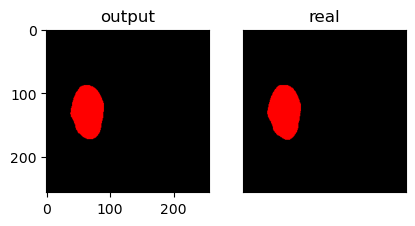

tensor(0)
outputs torch.Size([3, 256, 256])


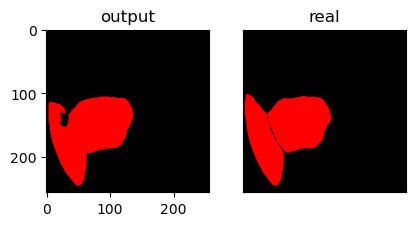

tensor(0)
outputs torch.Size([3, 256, 256])


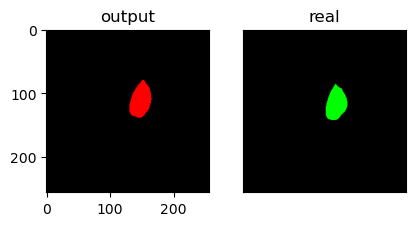

tensor(0)
outputs torch.Size([3, 256, 256])


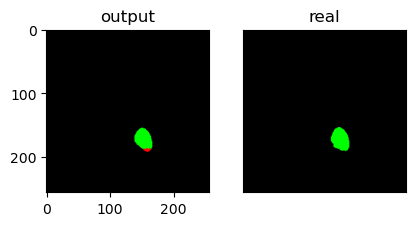

tensor(0)
outputs torch.Size([3, 256, 256])


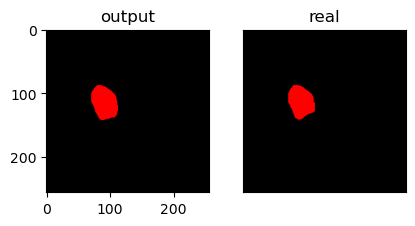

tensor(0)
outputs torch.Size([3, 256, 256])


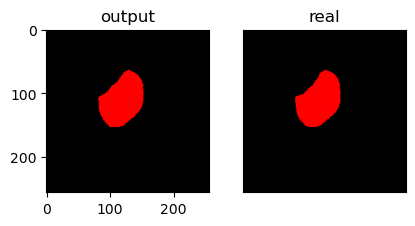

tensor(0)
outputs torch.Size([3, 256, 256])


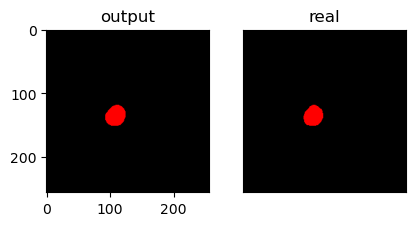

tensor(0)
outputs torch.Size([3, 256, 256])


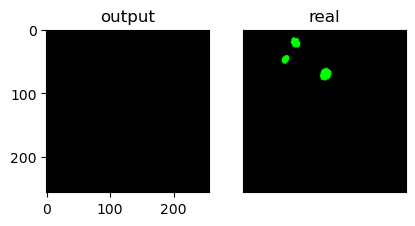

tensor(0)
outputs torch.Size([3, 256, 256])


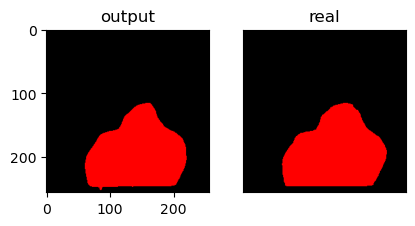

tensor(0)
outputs torch.Size([3, 256, 256])


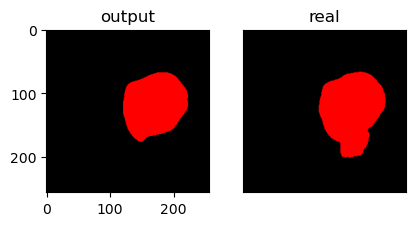

tensor(0)
outputs torch.Size([3, 256, 256])


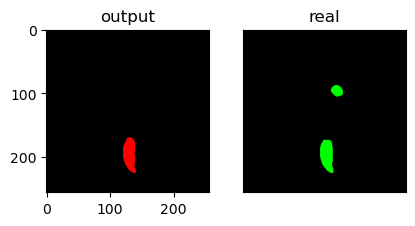

tensor(0)
outputs torch.Size([3, 256, 256])


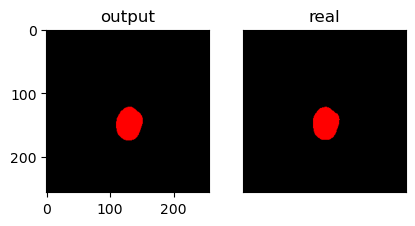

tensor(0)
outputs torch.Size([3, 256, 256])


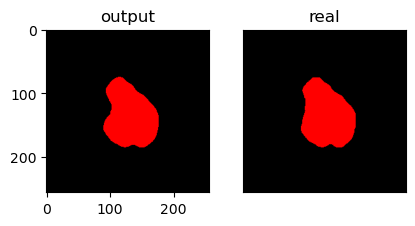

tensor(0)
outputs torch.Size([3, 256, 256])


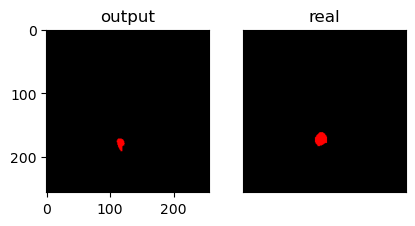

tensor(0)
outputs torch.Size([3, 256, 256])


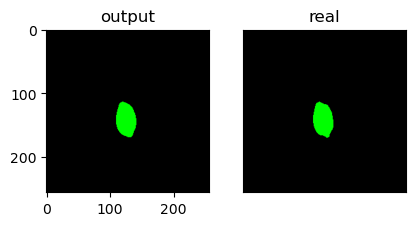

tensor(0)
outputs torch.Size([3, 256, 256])


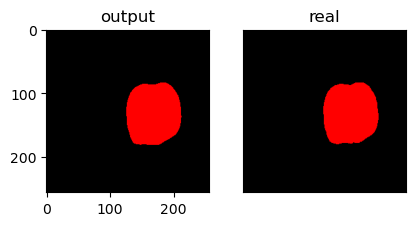

tensor(0)
outputs torch.Size([3, 256, 256])


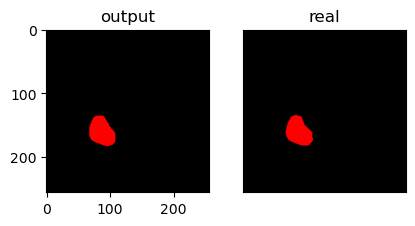

tensor(0)
outputs torch.Size([3, 256, 256])


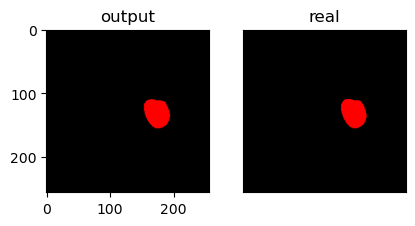

tensor(0)
outputs torch.Size([3, 256, 256])


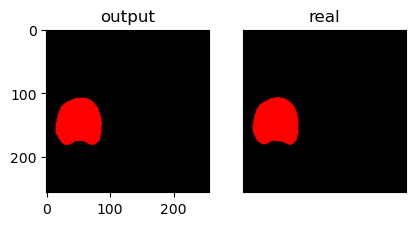

tensor(0)
outputs torch.Size([3, 256, 256])


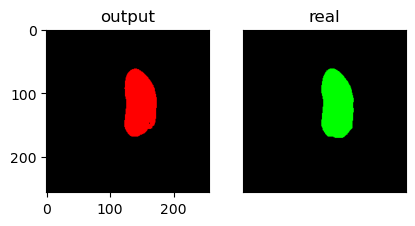

tensor(0)
outputs torch.Size([3, 256, 256])


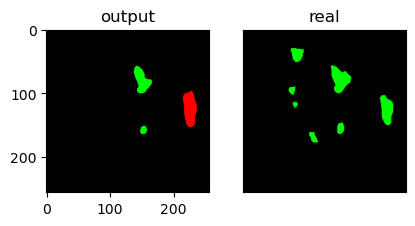

tensor(0)
outputs torch.Size([3, 256, 256])


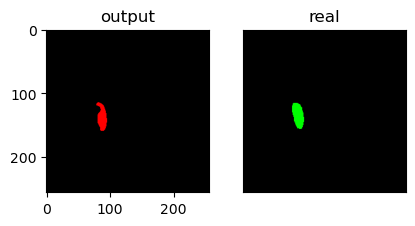

tensor(0)
outputs torch.Size([3, 256, 256])


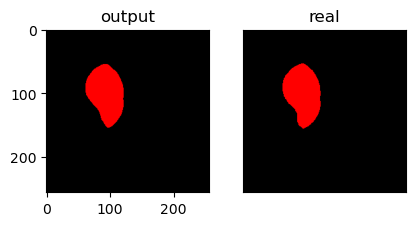

tensor(0)
outputs torch.Size([3, 256, 256])


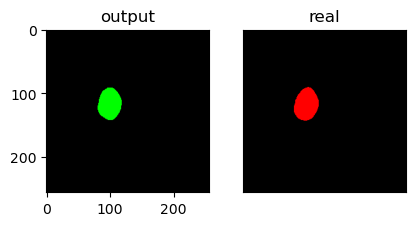

tensor(0)
outputs torch.Size([3, 256, 256])


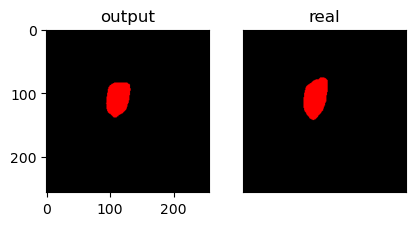

tensor(0)
outputs torch.Size([3, 256, 256])


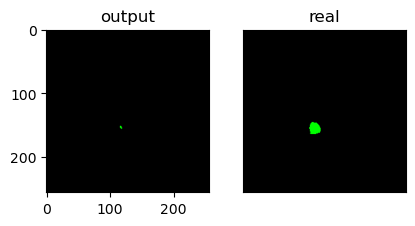

tensor(0)
outputs torch.Size([3, 256, 256])


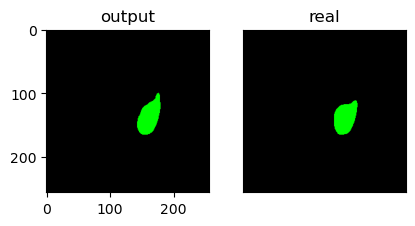

tensor(0)
outputs torch.Size([3, 256, 256])


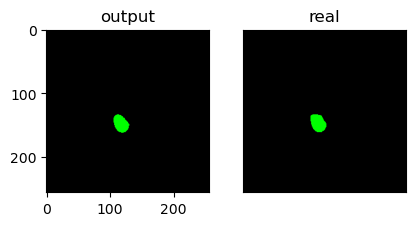

tensor(0)
outputs torch.Size([3, 256, 256])


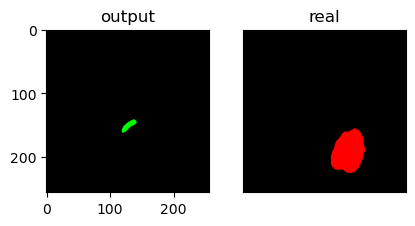

tensor(0)
outputs torch.Size([3, 256, 256])


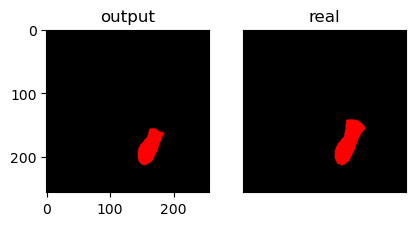

tensor(0)
outputs torch.Size([3, 256, 256])


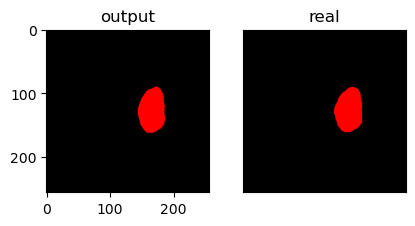

tensor(0)
outputs torch.Size([3, 256, 256])


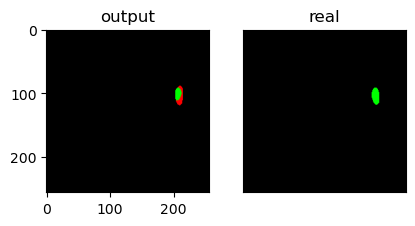

tensor(0)
outputs torch.Size([3, 256, 256])


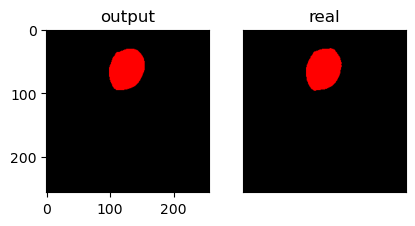

tensor(0)
outputs torch.Size([3, 256, 256])


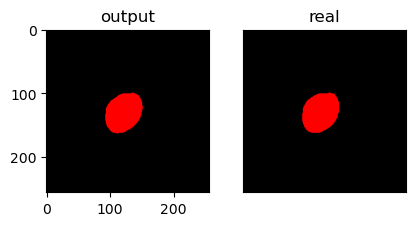

tensor(0)
outputs torch.Size([3, 256, 256])


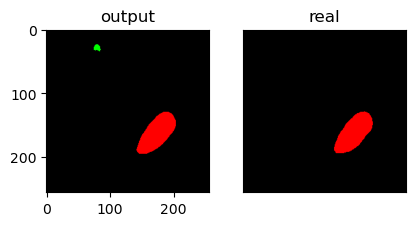

tensor(0)
outputs torch.Size([3, 256, 256])


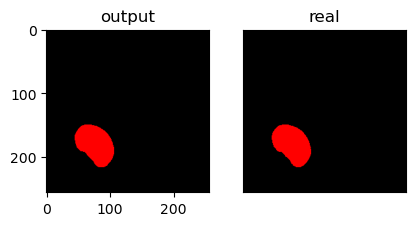

tensor(0)
outputs torch.Size([3, 256, 256])


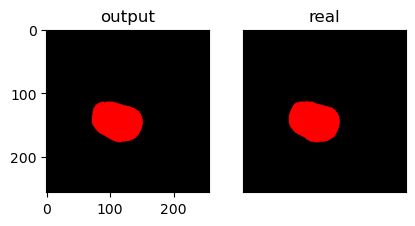

tensor(0)
outputs torch.Size([3, 256, 256])


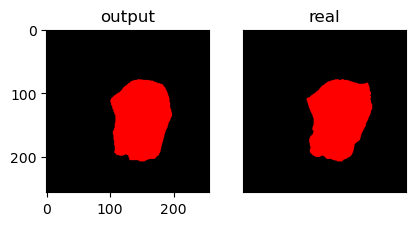

tensor(0)
outputs torch.Size([3, 256, 256])


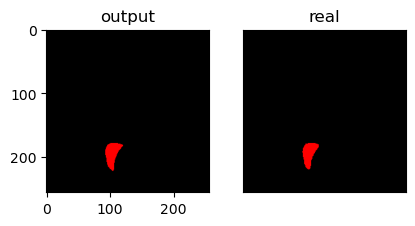

tensor(0)
outputs torch.Size([3, 256, 256])


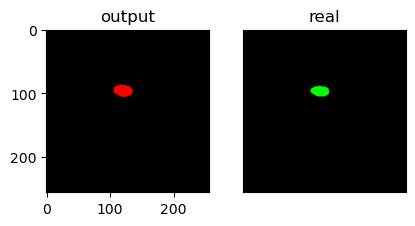

tensor(0)
outputs torch.Size([3, 256, 256])


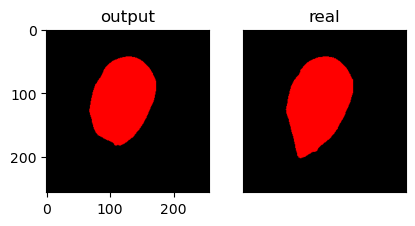

tensor(0)
outputs torch.Size([3, 256, 256])


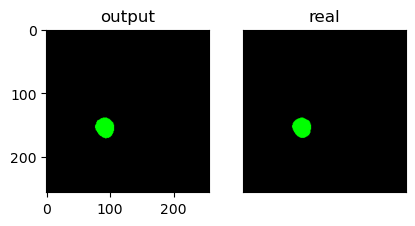

tensor(0)
outputs torch.Size([3, 256, 256])


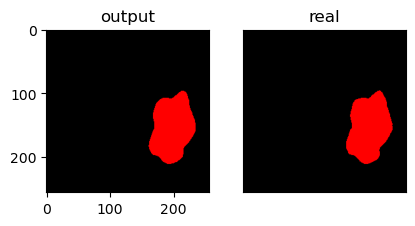

tensor(0)
outputs torch.Size([3, 256, 256])


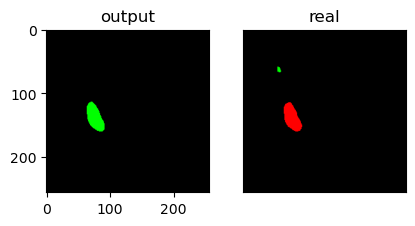

tensor(0)
outputs torch.Size([3, 256, 256])


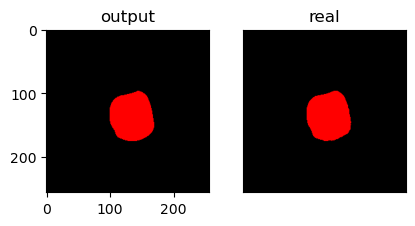

tensor(0)
outputs torch.Size([3, 256, 256])


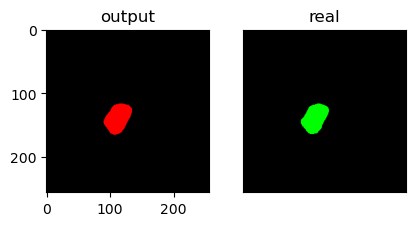

tensor(0)
outputs torch.Size([3, 256, 256])


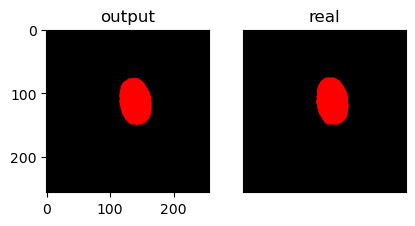

tensor(0)
outputs torch.Size([3, 256, 256])


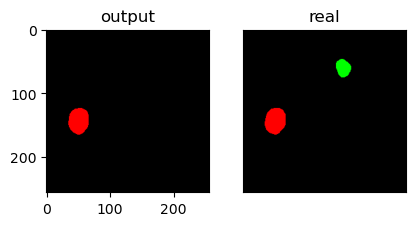

tensor(0)
outputs torch.Size([3, 256, 256])


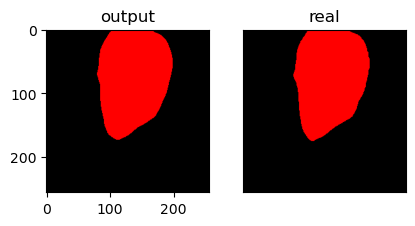

tensor(0)
outputs torch.Size([3, 256, 256])


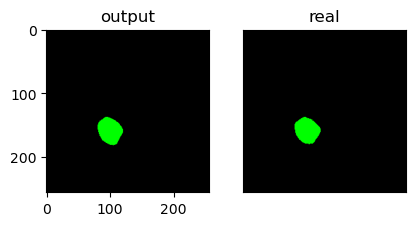

tensor(0)
outputs torch.Size([3, 256, 256])


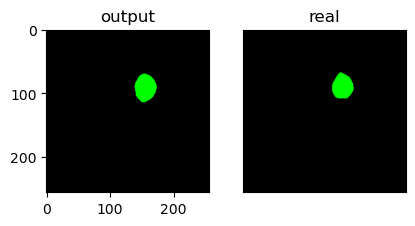

tensor(0)
outputs torch.Size([3, 256, 256])


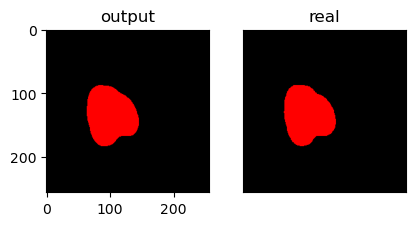

tensor(0)
outputs torch.Size([3, 256, 256])


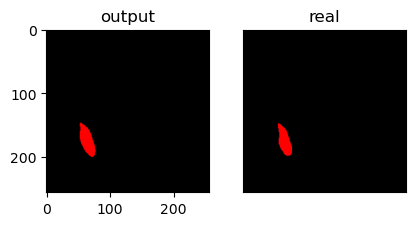

tensor(0)
outputs torch.Size([3, 256, 256])


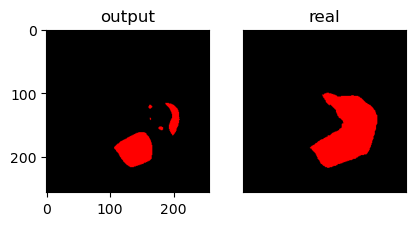

tensor(0)
outputs torch.Size([3, 256, 256])


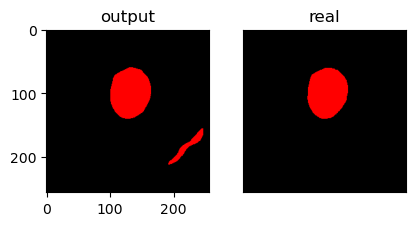

tensor(0)
outputs torch.Size([3, 256, 256])


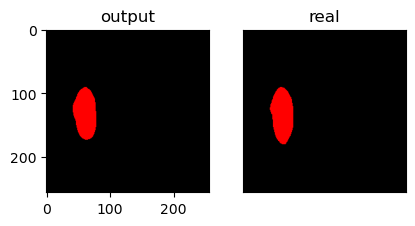

tensor(0)
outputs torch.Size([3, 256, 256])


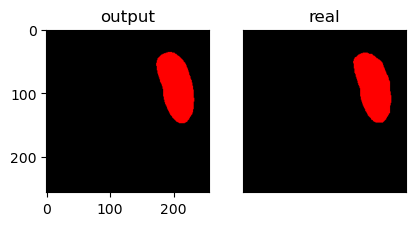

tensor(0)
outputs torch.Size([3, 256, 256])


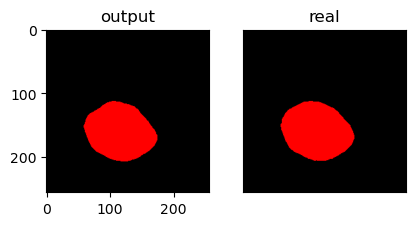

tensor(0)
outputs torch.Size([3, 256, 256])


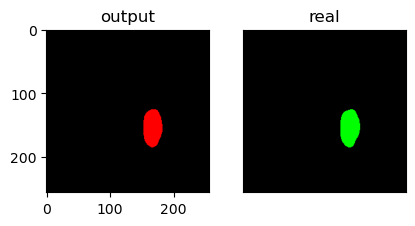

In [21]:
model = PolypModel()
checkpoint = torch.load('/kaggle/working/colorization_model_22.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth'))
# model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',map_location=torch.device('cpu')))
test_loader = DataLoader(test_dataset, batch_size=1)
# test_mask_loader = DataLoader(test_mask_dataset, batch_size=1)
# test_loader = DataLoader(train_dataset, batch_size=1)
# test_mask_loader = DataLoader(mask_dataset, batch_size=1)
model.eval()
loop=0
i=1
with torch.no_grad():
    for image,mask in test_loader:
        loop = loop +1
        if loop == 60:
            break
#         print(AB.shape)
        # Forward pass
        outputs = model(image)
        mask = mask.squeeze()
        outputs = outputs.squeeze()
        count = (outputs == 0).sum()
        print(count)
        print("outputs",outputs.shape)
        
#         outputs = outputs.astype(np.uint8)
#         print(outputs)
        outputs = np.argmax(outputs, axis=0)
#         print(outputs)

#         print(outputs.shape)
        outputs = mask_to_rgb(outputs, color_dict)
        mask = mask_to_rgb(mask, color_dict)
        
        
        plt.figure(figsize=(30,30))
        plt.subplot(12,12,i)
        plt.title('output')
        plt.imshow(outputs)
        plt.subplot(12,12,i+1)
        plt.title('real')
        plt.imshow(mask)


        i=i+2
        plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
        plt.show()


In [22]:
# model = PolypModel()
# checkpoint = torch.load('/kaggle/working/colorization_model_8.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# # model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth'))
# # model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',map_location=torch.device('cpu')))
# test_loader = DataLoader(test_dataset, batch_size=1)
# test_mask_loader = DataLoader(test_mask_dataset, batch_size=1)
# # test_loader = DataLoader(train_dataset, batch_size=1)
# # test_mask_loader = DataLoader(mask_dataset, batch_size=1)
# model.eval()
# loop=0
# i=1
# with torch.no_grad():
#     for RGB,RGBt in zip(test_loader, test_mask_loader):
#         loop = loop +1
#         if loop == 60:
#             break
# #         print(AB.shape)
#         # Forward pass
#         outputs = model(RGB)
#         RGBt = RGBt.squeeze()
#         outputs = outputs.squeeze()
#         count = (outputs == 0).sum()
#         print(count)
#         print("outputs",outputs.shape)
        
# #         outputs = outputs.astype(np.uint8)
# #         print(outputs)
#         outputs = np.argmax(outputs, axis=0)
# #         print(outputs)

# #         print(outputs.shape)
#         outputs = mask_to_rgb(outputs, color_dict)
#         RGBt = mask_to_rgb(RGBt, color_dict)
# #         output = mask_to_rgb(outputs, color_dict)
# #         output = ((output+0)*1).astype(np.uint8)

# #         output_image = np.zeros((224, 224, 3))
# #         output_image[:, :, 0:] = outputs.numpy().squeeze().transpose((1, 2, 0))      
# #         output_image[:, :, 0] = L.numpy().squeeze()
# #         output_image = ((output_image+1)*127.5).astype(np.uint8)
# #         output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

        
# #         intput_image = np.zeros((224, 224, 3))
# # #         intput_image[:, :, 0] = L.numpy().squeeze()
# #         intput_image[:, :, 0:] = RGBt
# #         intput_image = ((intput_image+1)*127.5).astype(np.uint8)
# # #         intput_image = cv2.cvtColor(intput_image, cv2.COLOR_LAB2RGB)

# #         # Convert output to RGB color space
# # #         output_image = cv2.cvtColor(output_image, cv2.COLOR_LAB2RGB)
        
        
#         plt.figure(figsize=(30,30))
#         plt.subplot(12,12,i)
#         plt.title('output')
#         plt.imshow(outputs)
#         plt.subplot(12,12,i+1)
#         plt.title('real')
#         plt.imshow(RGBt)

# # #         plt.imshow(output_image, interpolation = 'bicubic')
# #         ip_image = np.zeros((224, 224, 3))

        
# #         lab_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2LAB)
# #         Li, Ai, Bi = cv2.split(lab_image)
# # #         Li.fill(255)
# #         Ai.fill(128)
# #         Bi.fill(128)
# #         image_lab = cv2.merge([Li, Ai, Bi])

# #         # Convert back to RGB color space if needed
# #         image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
        
# #         plt.subplot(12,12,i)
# #         plt.title('input')
# #         plt.imshow(image_rgb)
#         i=i+2
#         # Check the size of L, A, B channels
#         plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
#         plt.show()


NameError: name 'test_mask_dataset' is not defined

In [ ]:
# model = PolypModel()
# checkpoint = torch.load('/kaggle/input/model-000001/colorization_model_20.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# # model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth'))
# # model.load_state_dict(torch.load('/kaggle/input/model-ver9h/colorization_model_49.pth',map_location=torch.device('cpu')))
# test_loader = DataLoader(test_dataset, batch_size=1)
# test_mask_loader = DataLoader(test_mask_dataset, batch_size=1)
# # test_loader = DataLoader(train_dataset, batch_size=1)
# # test_mask_loader = DataLoader(mask_dataset, batch_size=1)
# model.eval()
# loop=0
# i=1
# with torch.no_grad():
#     for L,AB in zip(test_loader, test_mask_loader):
#         loop = loop +1
#         if loop == 60:
#             break
# #         print(AB.shape)
#         # Forward pass
#         outputs = model(L)
#         output_image = np.zeros((224, 224, 3))
#         output_image[:, :, 1:] = outputs.numpy().squeeze().transpose((1, 2, 0))      
#         output_image[:, :, 0] = L.numpy().squeeze()
#         output_image = ((output_image+1)*127.5).astype(np.uint8)
        
#         intput_image = np.zeros((224, 224, 3))
#         intput_image[:, :, 0] = L.numpy().squeeze()
#         intput_image[:, :, 1:] = AB.numpy().squeeze().transpose((1, 2, 0))
#         intput_image = ((intput_image+1)*127.5).astype(np.uint8)
#         intput_image = cv2.cvtColor(intput_image, cv2.COLOR_LAB2RGB)

#         # Convert output to RGB color space
#         output_image = cv2.cvtColor(output_image, cv2.COLOR_LAB2RGB)
        
        
#         plt.figure(figsize=(30,30))
#         plt.subplot(12,12,i+1)
#         plt.title('output')
#         plt.imshow(output_image)
#         plt.subplot(12,12,i+2)
#         plt.title('real')
#         plt.imshow(intput_image)

# #         plt.imshow(output_image, interpolation = 'bicubic')
        
#         lab_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2LAB)
#         Li, Ai, Bi = cv2.split(lab_image)
# #         Li.fill(255)
#         Ai.fill(128)
#         Bi.fill(128)
#         image_lab = cv2.merge([Li, Ai, Bi])

#         # Convert back to RGB color space if needed
#         image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
        
#         plt.subplot(12,12,i)
#         plt.title('input')
#         plt.imshow(image_rgb)
#         i=i+3
#         # Check the size of L, A, B channels
#         plt.xticks([]), plt.yticks([]) # optional line of code, just to hide tick values on X and Y axis if needed
#         plt.show()
